# Ranking the sensors according to their importance/predictive power
#### Erik Isai Valle Salgado (valle.erik23@gmail.com)

In [1]:
# install dependencies
%pip install -qr requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
#Read data and add a numeric index
data = pd.read_csv("task_data.csv")
data.insert(0,"index", np.array(range(0,len(data))),True)
data.loc[200:400,"index"]=np.array(range(0,200))
# let's take a look of the data
data.head()

index sample index  class_label   sensor0   sensor1   sensor2   sensor3  \
0      0      sample0          1.0  0.834251  0.726081  0.535904  0.214896   
1      1      sample1          1.0  0.804059  0.253135  0.869867  0.334285   
2      2      sample2          1.0  0.694404  0.595777  0.581294  0.799003   
3      3      sample3          1.0  0.783690  0.038780  0.285043  0.627305   
4      4      sample4          1.0  0.788835  0.174433  0.348770  0.938244   

    sensor4   sensor5   sensor6   sensor7   sensor8   sensor9  
0  0.873788  0.767605  0.111308  0.557526  0.599650  0.665569  
1  0.604075  0.494045  0.833575  0.194190  0.014966  0.802918  
2  0.762857  0.651393  0.075905  0.007186  0.659633  0.831009  
3  0.800620  0.486340  0.827723  0.339807  0.731343  0.892359  
4  0.692065  0.377620  0.183760  0.616805  0.492899  0.930969

## 1. Understanding data
### Plotting data will help us to visualize the distribution of each sensor and pose a hypothesis. 

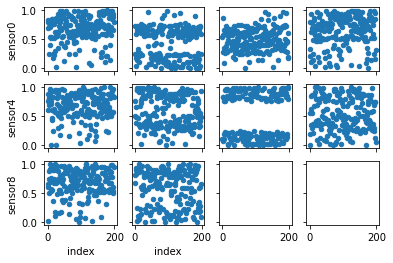

In [4]:
figure, axs = plt.subplots(3,4, sharey=True, sharex=True)
data[0:199].plot(kind="scatter", x="index", y="sensor0",ax=axs[0][0])
data[0:199].plot(kind="scatter", x="index", y="sensor1",ax=axs[0][1])
data[0:199].plot(kind="scatter", x="index", y="sensor2",ax=axs[0][2])
data[0:199].plot(kind="scatter", x="index", y="sensor3",ax=axs[0][3])
data[0:199].plot(kind="scatter", x="index", y="sensor4",ax=axs[1][0])
data[0:199].plot(kind="scatter", x="index", y="sensor5",ax=axs[1][1])
data[0:199].plot(kind="scatter", x="index", y="sensor6",ax=axs[1][2])
data[0:199].plot(kind="scatter", x="index", y="sensor7",ax=axs[1][3])
data[0:199].plot(kind="scatter", x="index", y="sensor8",ax=axs[2][0])
data[0:199].plot(kind="scatter", x="index", y="sensor9",ax=axs[2][1])

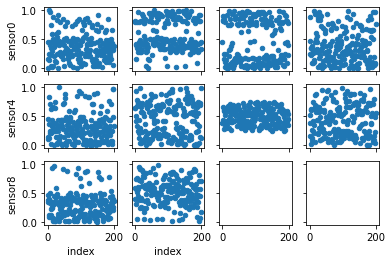

In [5]:
figure, axs = plt.subplots(3,4, sharey=True, sharex=True)
data[200:400].plot(kind="scatter", x="index", y="sensor0",ax=axs[0][0])
data[200:400].plot(kind="scatter", x="index", y="sensor1",ax=axs[0][1])
data[200:400].plot(kind="scatter", x="index", y="sensor2",ax=axs[0][2])
data[200:400].plot(kind="scatter", x="index", y="sensor3",ax=axs[0][3])
data[200:400].plot(kind="scatter", x="index", y="sensor4",ax=axs[1][0])
data[200:400].plot(kind="scatter", x="index", y="sensor5",ax=axs[1][1])
data[200:400].plot(kind="scatter", x="index", y="sensor6",ax=axs[1][2])
data[200:400].plot(kind="scatter", x="index", y="sensor7",ax=axs[1][3])
data[200:400].plot(kind="scatter", x="index", y="sensor8",ax=axs[2][0])
data[200:400].plot(kind="scatter", x="index", y="sensor9",ax=axs[2][1])

### We can also see the measures of dispersion to interpret the variablity of data.

In [6]:
stats1=data[0:199].describe(include=[np.number])
stats1.loc[8]=pd.array([data[0:199].var()[0],data[0:199].var()[1],data[0:199].var()[2],data[0:199].var()[3],data[0:199].var()[4],data[0:199].var()[5],data[0:199].var()[6],data[0:199].var()[7],data[0:199].var()[8], data[0:199].var()[9], data[0:199].var()[10], data[0:199].var()[11]])
del stats1['index'], stats1['class_label']
stats1.rename(index={8:'var'})

sensor0     sensor1     sensor2     sensor3     sensor4     sensor5  \
count  199.000000  199.000000  199.000000  199.000000  199.000000  199.000000   
mean     0.669187    0.440788    0.492577    0.638048    0.672013    0.566526   
std      0.221316    0.271552    0.187460    0.264387    0.220995    0.273447   
min      0.017610    0.003865    0.013799    0.014431    0.002246    0.002695   
25%      0.568975    0.173973    0.358932    0.503441    0.556458    0.334495   
50%      0.704567    0.556789    0.492250    0.694001    0.684985    0.495050   
75%      0.826130    0.661042    0.621129    0.851717    0.848613    0.845679   
max      0.999476    0.981556    0.975777    0.991156    0.999412    0.997367   
var      0.048981    0.073741    0.035141    0.069900    0.048839    0.074773   

          sensor6     sensor7     sensor8     sensor9  
count  199.000000  199.000000  199.000000  199.000000  
mean     0.486781    0.534614    0.676669    0.569926  
std      0.387103    0.284012    0.232137    0.313431  
min      0.000173    0.007186    0.003165    0.000452  
25%      0.126075    0.304751    0.549486    0.238218  
50%      0.226606    0.499249    0.710151    0.638128  
75%      0.872178    0.804686    0.866060    0.843207  
max      0.997141    0.998230    0.996098    0.999465  
var      0.149849    0.080663    0.053888    0.098239

In [7]:
stats2=data[200:400].describe(include=[np.number])
stats2.loc[8]=pd.array([data[200:400].var()[0],data[200:400].var()[1],data[200:400].var()[2],data[200:400].var()[3],data[200:400].var()[4],data[200:400].var()[5],data[200:400].var()[6],data[200:400].var()[7],data[200:400].var()[8], data[200:400].var()[9], data[200:400].var()[10], data[200:400].var()[11]])
del stats2['index'], stats2['class_label']
stats2.rename(index={8:'var'})

sensor0     sensor1     sensor2     sensor3     sensor4     sensor5  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.378135    0.578911    0.470101    0.380815    0.322972    0.436673   
std      0.230030    0.265070    0.361390    0.273244    0.237372    0.287962   
min      0.007775    0.004316    0.004473    0.001466    0.000250    0.000425   
25%      0.219088    0.375807    0.120978    0.150530    0.135061    0.153692   
50%      0.341919    0.494181    0.395372    0.328831    0.289807    0.501480   
75%      0.491499    0.842318    0.825923    0.555879    0.436274    0.682087   
max      0.999476    0.998680    0.992963    0.995119    0.999412    0.984338   
var      0.052914    0.070262    0.130603    0.074662    0.056345    0.082922   

          sensor6     sensor7     sensor8     sensor9  
count  200.000000  200.000000  200.000000  200.000000  
mean     0.492627    0.432786    0.287406    0.516104  
std      0.137776    0.271375    0.212170    0.221025  
min      0.248746    0.003453    0.003864    0.007976  
25%      0.377690    0.181374    0.124671    0.370568  
50%      0.484649    0.427769    0.283084    0.526702  
75%      0.610646    0.657933    0.392431    0.652790  
max      0.745404    0.975558    0.959601    0.982287  
var      0.018982    0.073644    0.045016    0.048852

## 2. Hypothesis
* I divided all sensors by cluster type as follows:

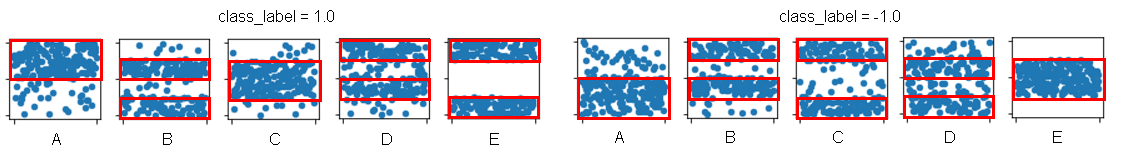

* Clearly, sensor6 has the best predictive power since both class labels do not have a significant dispersion among samples. The following table shows my prediction in decreasing order where the first sensor is the most important one. It is based on standard deviation, variance, and observation.

| Type A | Type B/D | Type C/E |
| --- | --- | --- |
| sensor8 | sensor1 | sensor6 |
| sensor0 | sensor5 | sensor2 |
| sensor4 | sensor7 | sensor9 |
| sensor3 | - | - |

* I decided to list both type B and D in the same column because $B\sim D^{c}$. C and E are similarly structured.
* Nevertheless, the result will depend on the method we use to rank the sensors

## 3. Analysis
*  This task is a typical example of Binary classification. Then, we can use some of the following methods:
> 1. Decision trees
> 2. Random forests
> 3. Logistic regression
> 4. Probit model
> 5. Bayesian networks
> 6. Support vector machines
> 7. Standard Neural networks

### Which option should we consider?

* **About 1,2, 3, 4, and 5:** I found a couple of solutions for this test on GitHub: the first approach used Logistic Regression [1], and the second a Random Tree [2]. An investigation [3] compared Random forest with logistic regression using 243 real datasets on different prediction tasks. It showed the effective average prediction performance of random forests compared to logistic regression, even with a standard implementation and default parameters. Regarding the Probit model, we know it is a generalized linear model used for modeling the relationship between one or more categorical/numerical predictor variables. Although logistic regression and probit models are similar, the difference between them is that they use different link functions. Therefore, **I discarded both logistic regression and probit model**. What about Decision Trees? DT learners can create over-complex trees that do not generalize the data well. They can be unstable cause minor variations in the data might result in a completely different tree. Indeed, They are not good at extrapolation. Bayesian networks (BN) can also be used as influence diagrams instead of decision trees. They are usually more compact, easier to build, and easier to modify than DT. Secondly, Bayesian networks may use direct probabilities (prevalence, sensitivity, specificity, etc.). Each parameter appears only once in a Bayesian network, and in case of need, the network may transform into a decision tree, while the reverse is not always possible [4]. Thus, **Random Forest is an option**.

* **About 6 and 7:** Each neuron of a standard NN model is equivalent to a logistic regression unit (or other non-linear activation functions). We find neurons organized in multiple layers with different connections. Although they may have a high performance learning non-linear functions, they require tons of data and are susceptible to local minimum traps. Similarly, SVMs are parametric and can deal with the same problem of classification against the same dataset. Notice that the given dataset may not be enough to train a NN model. Moreover, each sensor has readings arranged in clusters with significant noise, so we must add an error term to penalize the optimization and avoid a simple edge classification. Accordingly, the Support Vector Machine learns the decision boundary that maximizes the distance against the closest observations that belong to each cluster. Thus, **SMVs are another option**.

* **Random Forest vs SVM** Comparing both methods in practice will be crucial to solving this task,  so let's do it.

In [8]:
#IMPORTANT: Since this task is a binary classification example, we must use the classifier insted of the regressor!
#We set a seed to the random generator to get the same results anytime (random_state=0).
clfRF=RandomForestClassifier(oob_score=True, random_state=0)
clfRF.fit(data.values[:,3:],data['class_label'].values) #fit sensor values according to the class label
imp_randfor = sorted(zip(clfRF.feature_importances_, data.columns.values[3:]), reverse=True)
print("Random Forest Classifier")
imp_randfor

Random Forest Classifier


[(0.25775064128346353, 'sensor8'),
 (0.24627450332924097, 'sensor6'),
 (0.18356644361404645, 'sensor4'),
 (0.11368711566266688, 'sensor0'),
 (0.07064508607552492, 'sensor2'),
 (0.038589891800966385, 'sensor3'),
 (0.033246314936122234, 'sensor1'),
 (0.022112871196626326, 'sensor9'),
 (0.017520229375632957, 'sensor7'),
 (0.016606902725709426, 'sensor5')]

In [9]:
#This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
clfET=ExtraTreesClassifier(random_state=0, n_estimators=200) #default=100
clfET.fit(data.values[:,3:],data['class_label'].values) #fit sensor values according to the class label
imp_exttree = sorted(zip(clfET.feature_importances_, data.columns.values[3:]), reverse=True)
print("Extra Tree Classifier")
imp_exttree

Extra Tree Classifier


[(0.2116445733046267, 'sensor6'),
 (0.2009073420909542, 'sensor8'),
 (0.18079559990649777, 'sensor4'),
 (0.12094633161927898, 'sensor0'),
 (0.0766877550044305, 'sensor2'),
 (0.06825111154888452, 'sensor3'),
 (0.05290844092923144, 'sensor1'),
 (0.03439529628018304, 'sensor5'),
 (0.02940248515360463, 'sensor9'),
 (0.024061064162308292, 'sensor7')]

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model [5].

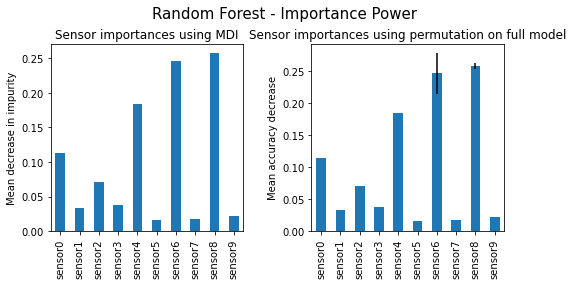

In [10]:
RF_imp = pd.Series(clfRF.feature_importances_, index=data.columns.values[3:])
stdRF = np.std([clfRF.feature_importances_ for tree in clfRF.estimators_], axis=0)#MDI

X_train, X_test, y_train, y_test = train_test_split(data.values[:,3:], data['class_label'].values, stratify=data['class_label'].values, random_state=0)
pfiRF = permutation_importance(clfRF, X_test, y_test, n_repeats=100, random_state=0, n_jobs=2) #Permutation Feature Importance
pfiRF_imp = pd.Series(pfiRF.importances_mean, index=data.columns.values[3:])

fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.suptitle('Random Forest - Importance Power', fontsize=15)
ax1=plt.subplot(1,2,1)
RF_imp.plot.bar(yerr=stdRF)
ax1.set_title("Sensor importances using MDI")
ax1.set_ylabel("Mean decrease in impurity")

ax2=plt.subplot(1,2,2)
RF_imp.plot.bar(yerr=pfiRF.importances_std)
ax2.set_title("Sensor importances using permutation on full model")
ax2.set_ylabel("Mean accuracy decrease")

fig.tight_layout()
fig.subplots_adjust(top=0.85)

Extra Tree Classifier


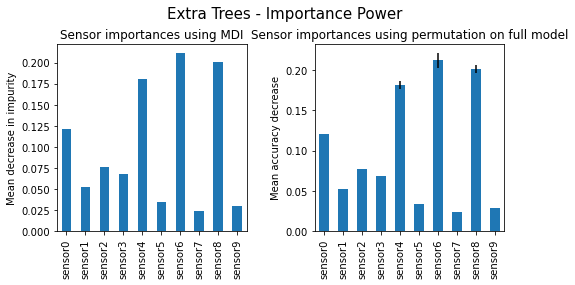

In [11]:
ET_imp = pd.Series(clfET.feature_importances_, index=data.columns.values[3:])
stdET = np.std([clfRF.feature_importances_ for tree in clfRF.estimators_], axis=0)
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.suptitle('Extra Trees - Importance Power', fontsize=15)
ax3=plt.subplot(1,2,1)
ET_imp.plot.bar(yerr=stdET)
ax3.set_title("Sensor importances using MDI")
ax3.set_ylabel("Mean decrease in impurity")

ax4=plt.subplot(1,2,2)
pfiET = permutation_importance(clfET, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2) #Permutation Feature Importance
pfiET_imp = pd.Series(pfiET.importances_mean, index=data.columns.values[3:])
ET_imp.plot.bar(yerr=pfiET.importances_std)
ax4.set_title("Sensor importances using permutation on full model")
ax4.set_ylabel("Mean accuracy decrease")
print("Extra Tree Classifier")
fig.tight_layout()
fig.subplots_adjust(top=0.85)

Indeed, the same features are detected as most important using both methods.

## What about SVM and the other methods?
I will use Linear and RBF SVMs to classify the dataset. Moreover, I decided to compare our proposals with other classifiers as well.  

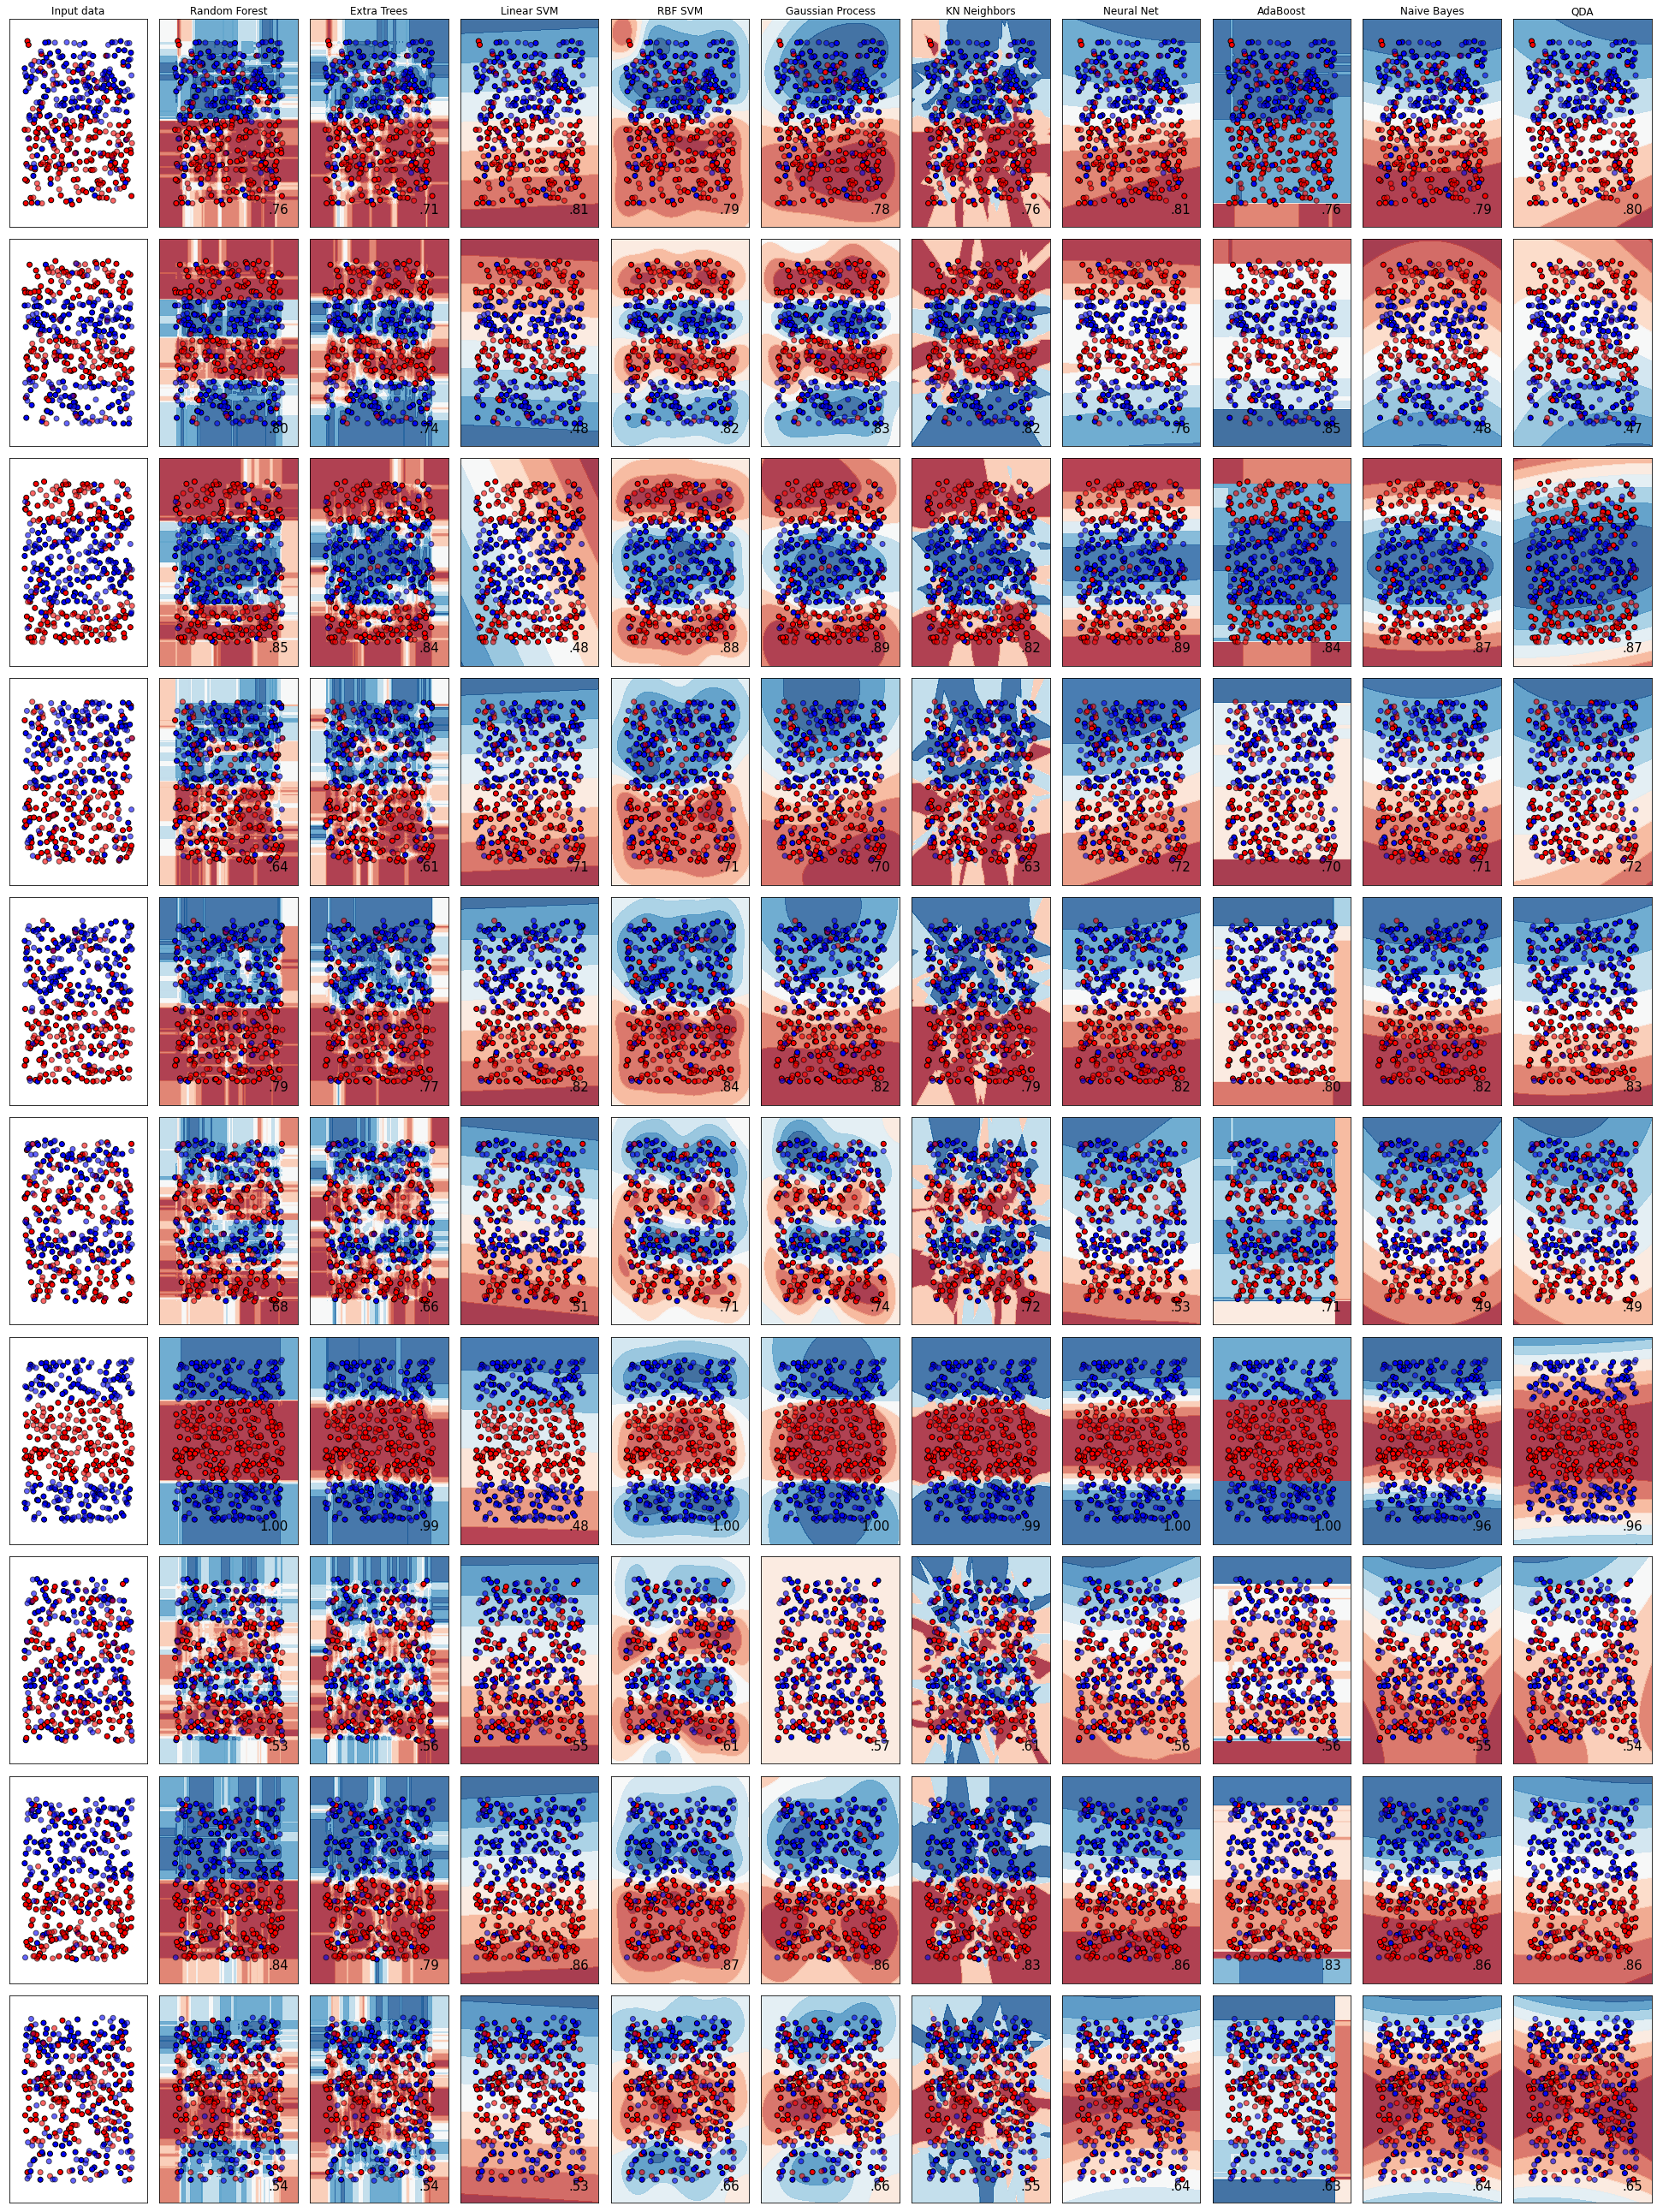

In [12]:
#Similar code here: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

h = .01  # step size in the mesh

names = ["Random Forest", "Extra Trees", "Linear SVM", "RBF SVM", "Gaussian Process",
         "KN Neighbors", "Neural Net", "AdaBoost", "Naive Bayes", "QDA"]

classifiers = [
    RandomForestClassifier(oob_score=True, random_state=0),
    ExtraTreesClassifier(random_state=0, n_estimators=200),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(3),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

## Dataset
s=[]
s0=[]
sensors=data.columns.values[3:]

for i in range(0,len(sensors)):
    for j in range(0,len(data[sensors[i]])):
        s0.append([data["index"][j], data[sensors[i]][j]])
    d=np.array(s0)
    s.append(d)
    s0=[]
y=data['class_label'].values
datasets=[[s[0],y],[s[1],y],[s[2],y],[s[3],y],[s[4],y],[s[5],y],[s[6],y],[s[7],y],[s[8],y],[s[9],y]]
#datasets=[[s[0],y],[s[1],y]]
scores=[]
figure = plt.figure(figsize=(27, 36))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=0)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    senscore=[]
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        senscore.append(score)        

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
    if(ds_cnt==0):
        scores=senscore
    else:
        scores=np.vstack((scores,senscore))
plt.tight_layout()
plt.show()

### Which classifier achieved the highest accuracy score?

In [13]:
best_clf=np.zeros(len(scores))
for i in range(0,10):
    maximo=np.where(scores[i]==scores[i].max())
    #print(i, maximo)
    for j in range(0,len(maximo[0][:])):
        best_clf[maximo[0][j]]=best_clf[maximo[0][j]]+1
best_clf_in=np.where(best_clf==best_clf.max())
print("The", names[best_clf_in[0][0]],"classifier achieved the highest accuracy for all sensors.")
imp_clf=sorted(zip(np.transpose(scores)[best_clf_in[0][0]], data.columns.values[3:]), reverse=True)
imp_clf

The RBF SVM classifier achieved the highest accuracy for all sensors.


[(1.0, 'sensor6'),
 (0.875, 'sensor2'),
 (0.86875, 'sensor8'),
 (0.8375, 'sensor4'),
 (0.825, 'sensor1'),
 (0.7875, 'sensor0'),
 (0.7125, 'sensor5'),
 (0.7125, 'sensor3'),
 (0.6625, 'sensor9'),
 (0.60625, 'sensor7')]

### Each classifier has a different ranking. For instance, The Gaussian Process has a slightly unequal list:

In [14]:
sec_clf=sorted(zip(np.transpose(scores)[4], data.columns.values[3:]), reverse=True)
sec_clf

[(1.0, 'sensor6'),
 (0.8875, 'sensor2'),
 (0.8625, 'sensor8'),
 (0.83125, 'sensor1'),
 (0.81875, 'sensor4'),
 (0.78125, 'sensor0'),
 (0.7375, 'sensor5'),
 (0.7, 'sensor3'),
 (0.6625, 'sensor9'),
 (0.575, 'sensor7')]

### Finally, we will store the ranked list of sensors in a csv file.

In [15]:
df = pd.DataFrame(imp_clf)
d = {'accuracy' : df[0], 
     names[best_clf_in[0][0]] : df[1]}
df=pd.DataFrame(d)
df=df.drop(["accuracy"], axis=1)
df.to_csv('ranked_list_of_sensors.csv', index=False)

## 4. Conclusion

We analyzed the dataset of 400 samples, where for each sample there are ten different sensor readings available. Since this is a binary classification example, we decided to look at various methods to select one. First, we proposed Decision trees, Random forests, Logistic regression, Probit model, Bayesian networks, Support vector machines, and Standard Neural networks. We compared the results of Random Forest with SVM to achieve an accurate ranking of sensors based on their importance/predictive power. Then, we added other approaches to our analysis, such as KN Neighbors, AdaBoost, Naive Bayes, and QDA. After plotting the nature of decision boundaries of different classifiers, we noticed that Radial Basis Functions SVM had the best performance and stored its ranked list of sensors according to its accuracy.

## Biography
    [1] O. Potkin, "GitHub," 1 May 2018. [Online]. Available: https://github.com/olpotkin/CeleraOne-Solution. [Accessed 30 September 2021].
    [2] V. Kesti, "GitHub," 16 September 2019. [Online]. Available: https://github.com/vishalkesti382/Industrial-sensors-data-feature-importance. [Accessed 30 September 2021].
    [3] R. Couronné, P. Probst and A. Boulesteix, "Random forest versus logistic regression: a large-scale benchmark experiment," in BMC Bioinformatics, 2018. 
    [4] M. Horný, "Bayesian Networks," Boston University, Boston, Massachusetts.
    [5] F. Pedregosa, et.al., "Scikit-learn: Machine Learning in Python," Journal of Machine Learning Research, vol. 12, pp. 2825-2830, 2011. 